# Stage 10a – Linear Regression Project

Baseline regression model on engineered features to predict daily returns.

In [1]:
import os
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# paths
repo = Path.cwd().parents[1] if (Path.cwd().name == "notebooks") else Path.cwd()
data_dir = repo / "project" / "data" / "processed"
features_path = data_dir / "IYR_features_project.csv"   # from Stage 9

df = pd.read_csv(features_path)

# basic cleaning
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.sort_values("Date")

df = df.replace([np.inf, -np.inf], np.nan).dropna()
df.head()

,Date,Close,High,Low,Open,Volume,daily_return,ret_lag1,ret_lag5,ma_7,...,vol_7,vol_21,vol_63,mom_10,mom_20,mom_60,cum_return,ema_12,ema_26,rsi_14
60,2022-03-31,99.167297,100.89003109613013,98.89238984611272,100.67010927710845,11802300,-0.010515,-0.006811,0.006376,98.086923,...,0.014513,0.011485,0.012759,0.028786,0.044609,-0.055367,-0.057170,97.537511,96.363382,70.096662
61,2022-04-01,100.825882,100.89919155778817,99.0481626148692,99.39637971823183,8195800,0.016725,-0.010515,0.011658,98.877993,...,0.013447,0.011839,0.012850,0.044015,0.056898,-0.010229,-0.041401,98.043415,96.693938,76.863454
62,2022-04-04,100.459343,101.1282808333186,99.60713806784467,100.89919357282109,6140300,-0.003635,0.016725,0.011335,99.529908,...,0.014183,0.011915,0.012752,0.045754,0.075063,-0.013650,-0.044886,98.415096,96.972857,73.769000
63,2022-04-05,100.129463,101.48566294148044,99.77208760568571,100.14779409288757,8433700,-0.003284,-0.003635,0.028486,99.974991,...,0.014443,0.010793,0.012755,0.039456,0.077531,-0.010238,-0.048022,98.678845,97.206680,69.554748
64,2022-04-06,101.302399,101.44901090639082,99.20395834403645,99.58882329909336,9412400,0.011714,-0.003284,-0.006811,100.430546,...,0.014473,0.010738,0.012296,0.063114,0.072978,0.006440,-0.036870,99.082468,97.510066,69.048861


In [2]:
# choose target column (prefer a forward-looking target if present)
candidates = ["next_return", "target", "y", "daily_return"]
y_col = next((c for c in candidates if c in df.columns), None)
if y_col is None:
    raise ValueError(f"No target column found. Looked for: {candidates}")

# features = all numeric columns except target and Date
drop_cols = set([y_col, "Date"])
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
X_cols = [c for c in num_cols if c not in drop_cols]

X = df[X_cols].values
y = df[y_col].values

len(X_cols), X_cols[:10]

(17,
 ['Close',
  'ret_lag1',
  'ret_lag5',
  'ma_7',
  'ma_21',
  'ma_63',
  'ma_126',
  'vol_7',
  'vol_21',
  'vol_63'])

In [3]:
n = len(df)
split = int(n * 0.8)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
dates_train = df["Date"].iloc[:split] if "Date" in df.columns else None
dates_test  = df["Date"].iloc[split:]  if "Date" in df.columns else None

len(X_train), len(X_test)

(348, 88)

In [4]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2   = r2_score(y_test, y_pred)

print("MAE :", round(mae, 6))
print("RMSE:", round(rmse, 6))
print("R^2 :", round(r2, 6))

# coefficients table
coef_tbl = pd.DataFrame(
    {"feature": X_cols, "coef": linreg.coef_}
).sort_values("coef", ascending=False)
coef_tbl.head(10)

MAE : 0.005209
RMSE: 0.00652
R^2 : 0.722508


,feature,coef
9,vol_63,0.667025
11,mom_20,0.192667
13,cum_return,0.047119
15,ema_26,0.024418
3,ma_7,0.021971
4,ma_21,0.013403
0,Close,0.011545
16,rsi_14,0.000167
6,ma_126,-0.000943
5,ma_63,-0.003247


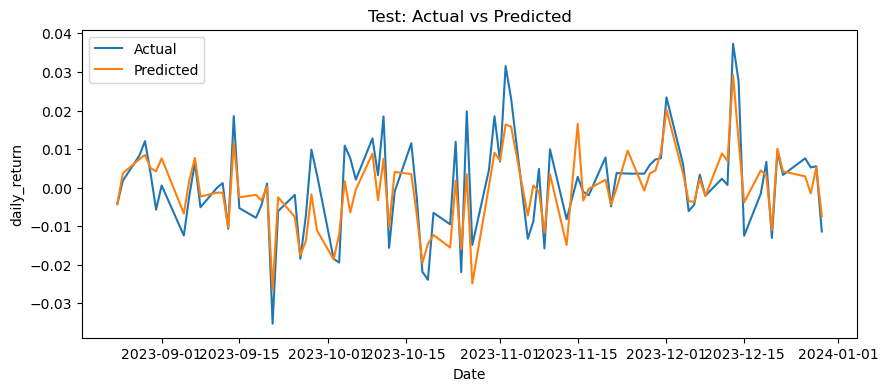

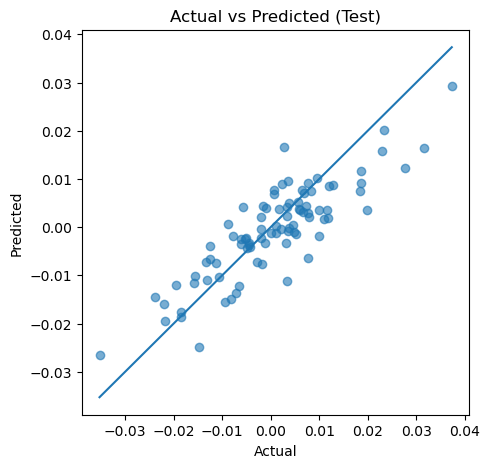

In [5]:
# line plot over time if Date exists
if dates_test is not None:
    plt.figure(figsize=(10,4))
    plt.plot(dates_test, y_test, label="Actual")
    plt.plot(dates_test, y_pred, label="Predicted")
    plt.title("Test: Actual vs Predicted")
    plt.xlabel("Date"); plt.ylabel(y_col); plt.legend(); plt.show()

# scatter actual vs predicted
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title("Actual vs Predicted (Test)")
plt.xlabel("Actual"); plt.ylabel("Predicted")
# reference line
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)
plt.show()

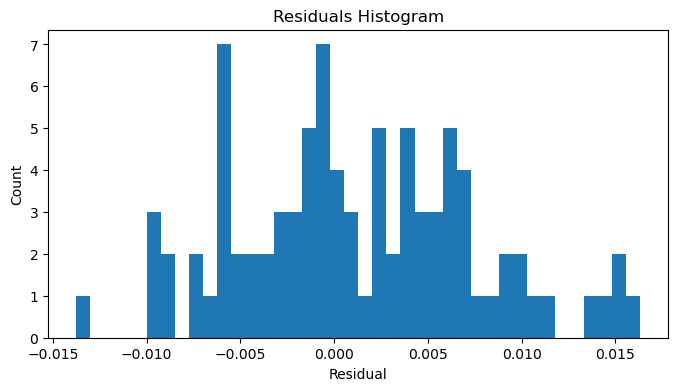

count    88.000000
mean      0.001250
std       0.006436
min      -0.013751
25%      -0.002975
50%       0.000570
75%       0.005791
max       0.016313
dtype: float64

In [6]:
resid = y_test - y_pred

plt.figure(figsize=(8,4))
plt.hist(resid, bins=40)
plt.title("Residuals Histogram")
plt.xlabel("Residual"); plt.ylabel("Count")
plt.show()

pd.Series(resid).describe()

In [7]:
import pickle

out_pred_path = data_dir / "IYR_linreg_predictions_project.csv"
out_model_dir = repo / "project" / "model"
out_model_dir.mkdir(parents=True, exist_ok=True)
out_model_path = out_model_dir / "linreg_project.pkl"

# predictions file
out_df = pd.DataFrame({
    "Date": dates_test.values if dates_test is not None else np.arange(len(y_test)),
    "y_test": y_test,
    "y_pred": y_pred
})
out_df.to_csv(out_pred_path, index=False)

# model pickle
with open(out_model_path, "wb") as f:
    pickle.dump({"model": linreg, "features": X_cols, "target": y_col}, f)

print("Saved:", out_pred_path)
print("Saved:", out_model_path)

Saved: /Users/ivysingal/bootcamp_ivy_singal/project/data/processed/IYR_linreg_predictions_project.csv
Saved: /Users/ivysingal/bootcamp_ivy_singal/project/model/linreg_project.pkl


In [8]:
summary = {
    "rows": len(df),
    "features_used": len(X_cols),
    "target": y_col,
    "MAE": float(mae),
    "RMSE": float(rmse),
    "R2": float(r2),
    "predictions_csv": str(out_pred_path.relative_to(repo)),
    "model_pickle": str(out_model_path.relative_to(repo)),
}
pd.Series(summary)

rows                                                             436
features_used                                                     17
target                                                  daily_return
MAE                                                         0.005209
RMSE                                                         0.00652
R2                                                          0.722508
predictions_csv    project/data/processed/IYR_linreg_predictions_...
model_pickle                        project/model/linreg_project.pkl
dtype: object